<a href="https://colab.research.google.com/github/alexandrufalk/Background-generator/blob/Layout-page/05__Transfer_Learning_with_TensorFlow_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In fine-tuning transfer learning the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

In [13]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [7]:
# Get helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-04-29 12:18:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-04-29 12:18:41 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [8]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2024-04-29 12:18:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  97.4MB/s    in 1.7s    

2024-04-29 12:18:45 (97.4 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:

# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [16]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [17]:
# Create data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=32)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:

# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Model 0: Building a transfer learning model using the Keras Functional API

# 1. Create base model with tf.keras.applications
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

#2 Freeze the base model (so the pre-learned patterns remain)

base_model.trainabke=False

# 3 Create inputs into the base  model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5 Pass the inputs to the base_model
x=base_model(inputs)
#Check data shape after passing it to base_model
print(f'Shape after base_moedl:{x.shape}')

#6 Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D:{x.shape}")

#7 create the output activation layer
oututs=tf.keras.layers.Dense(10, activation='softmax', name="output-layer")(x)

#8 Combine he inputs with the outputs into a model
model_0=tf.keras.Model(inputs,oututs)

#9 Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#10 Fit the model
history0=model_0.fit(train_data_10_percent,
                     epochs=5,
                     steps_per_epoch=len(train_data_10_percent),
                     validation_data=test_data_10_percent,
                     validation_steps=int(0.25*len(test_data_10_percent)),
                     callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extract")])

24274472/24274472 [==============================] - 3s 0us/step
Shape after base_moedl:(None, 7, 7, 1280)
Shape after GlobalAveragePooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240423-063032
Epoch 1/5
24/24 [==============================] - 59s 528ms/step - loss: 1.5004 - accuracy: 0.5253 - val_loss: 0.5486 - val_accuracy: 0.8405
Epoch 2/5
24/24 [==============================] - 8s 308ms/step - loss: 0.3827 - accuracy: 0.8880 - val_loss: 0.6439 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 7s 262ms/step - loss: 0.1189 - accuracy: 0.9747 - val_loss: 0.5748 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 8s 308ms/step - loss: 0.1740 - accuracy: 0.9400 - val_loss: 0.8838 - val_accuracy: 0.7681
Epoch 5/5
24/24 [==============================] - 8s 308ms/step - loss: 0.1158 - accuracy: 0.9640 - val_loss: 0.7426 - val_accuracy: 0.7911


In [ ]:
# Check layers in ur model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output-layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 5871514 (22.40 MB)
Non-trainable params: 60608 (236.75 KB)
_________________

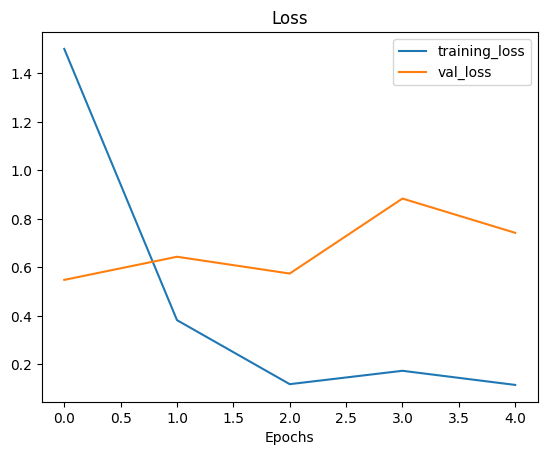

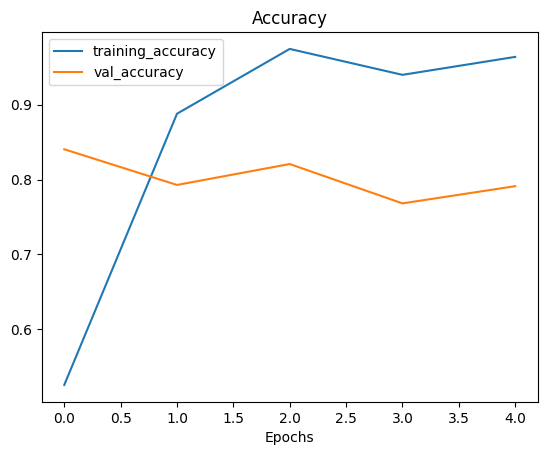

In [ ]:
#Check the loss curve
plot_loss_curves(history0)

#Getting a feature vector from a trained model

In [14]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape=(1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [5]:

# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

#Running a series of transfer learning experiments

Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.

Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.

Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.

Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.


In [9]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-04-29 12:19:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   188MB/s    in 0.7s    

2024-04-29 12:19:09 (188 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [13]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [17]:
import tensorflow as tf
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         batch_size=32,
                                                                         image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#Adding data augmentation right into the model

Using the tf.keras.layers module and creating a dedicated data augmentation layer.
The data augmentation transformations we're going to use are:

tf.keras.layers.RandomFlip - flips image on horizontal or vertical axis.

tf.keras.layersRandomRotation - randomly rotates image by a specified amount.

tf.keras.layers.RandomZoom - randomly zooms into an image by specified amount.

tf.keras.layers.RandomHeight - randomly shifts image height by a specified amount.

tf.keras.layers.RandomWidth - randomly shifts image width by a specified amount.

tf.keras.layers.Rescaling - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using tf.keras.applications.efficientnet_v2.EfficientNetV2B0, it's not required (the model pretrained model implements rescaling itself).

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation

data_augmentation=keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
])



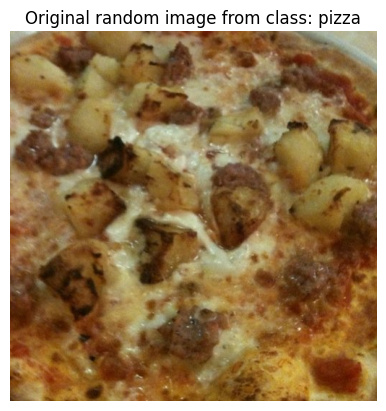

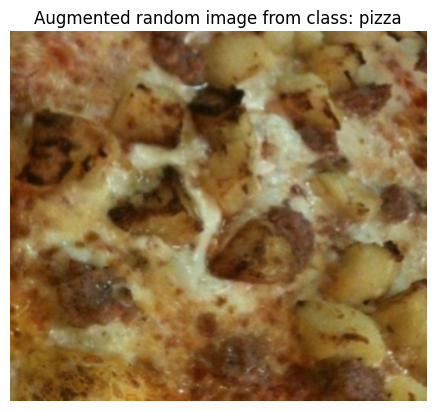

In [18]:
#View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/" + target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+ "/"+ random_image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

#Augment the image
augmented_img=data_augmentation(tf.expand_dims(img,axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
#Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

#base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

#Create the input layer


inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240423-133327
Epoch 1/5
3/3 [==============================] - 19s 4s/step - loss: 2.3954 - accuracy: 0.0857 - val_loss: 2.2585 - val_accuracy: 0.1464
Epoch 2/5
3/3 [==============================] - 6s 2s/step - loss: 2.1643 - accuracy: 0.2000 - val_loss: 2.1334 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9891 - accuracy: 0.4286 - val_loss: 2.0282 - val_accuracy: 0.3158
Epoch 4/5
3/3 [==============================] - 6s 2s/step - loss: 1.9035 - accuracy: 0.4857 - val_loss: 1.9475 - val_accuracy: 0.3750
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.7125 - accuracy: 0.5714 - val_loss: 1.8468 - val_accuracy: 0.4441


In [ ]:

# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 88ms/step - loss: 1.8647 - accuracy: 0.4128


[1.8646599054336548, 0.41280001401901245]

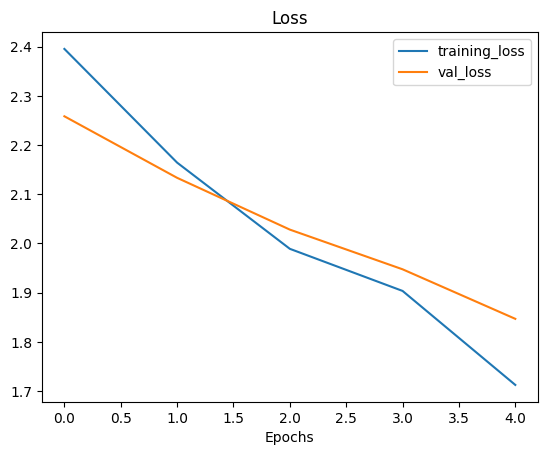

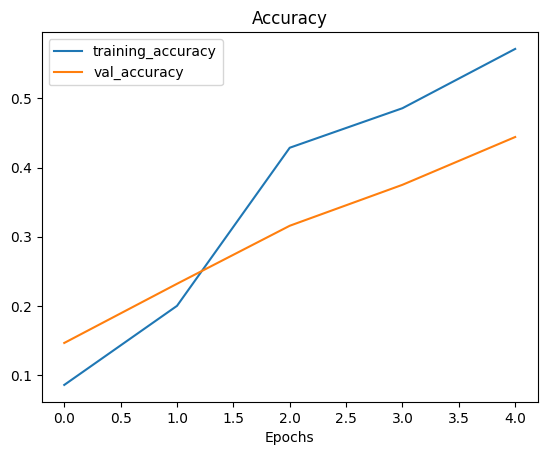

In [ ]:

plot_loss_curves(history_1_percent)

In [3]:
#Model 2: Feature extraction transfer learning with 10% of data and data augmentation

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [10]:
#Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation=keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

#Setup the input shape
input_shape=(224,224,3)

#Create a frozen base model
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

#Create input and output layers
inputs=layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(inputs) #augment our training images
x=base_model(x,training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=layers.Dense(10,activation="softmax",name="output_layer")(x)
model2=tf.keras.Model(inputs,outputs)

24274472/24274472 [==============================] - 0s 0us/step


In [52]:
#COmpile the model
model2.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])

In [50]:
#Setup checkpoint path

checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Create a ModelCCheckpoint callback

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weight_only=True, # set to False to save the entire model
                                                       save_best_only=True, # save only the best model weights instead of a model every epoch
                                                       save_freq="epoch", # save every epoch
                                                       verbose=1)

In [53]:
#Fit the model
initial_epochs=5
history_10_percent_data_aug=model2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240429-130831
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.4143 - accuracy: 0.5133
Epoch 1: val_loss improved from inf to 0.62966, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 80s 3s/step - loss: 1.4143 - accuracy: 0.5133 - val_loss: 0.6297 - val_accuracy: 0.7911
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.7907
Epoch 2: val_loss improved from 0.62966 to 0.50193, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 56s 2s/step - loss: 0.6953 - accuracy: 0.7907 - val_loss: 0.5019 - val_accuracy: 0.8339
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.8400
Epoch 3: val_loss improved from 0.50193 to 0.44616, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=======

In [32]:
# Evaluate on the test data
results_10_percent_data_aug = model2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 8s 88ms/step - loss: 0.6575 - accuracy: 0.8260


[0.6574548482894897, 0.8259999752044678]

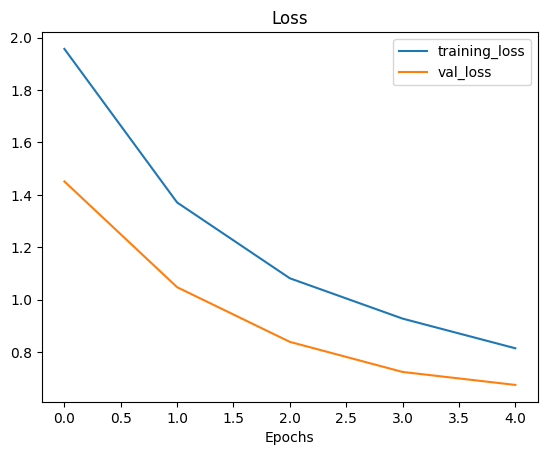

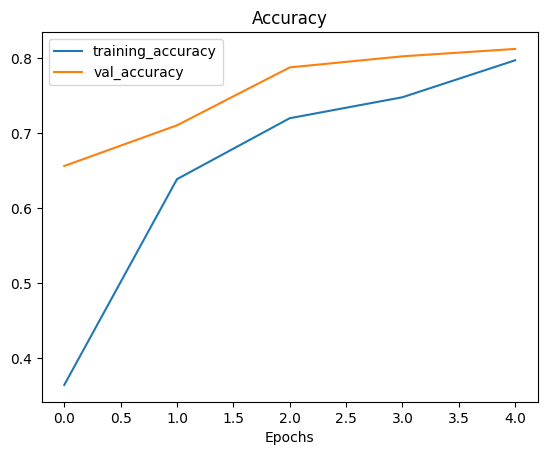

In [33]:
#Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [34]:
#Load in saved model wights and evaluate model
model2.load_weights(checkpoint_path)
loaded_weights_model_results=model2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6575 - accuracy: 0.8260


In [36]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))


array([ True,  True])

In [37]:

# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


In [1]:
#Model 3: Fine-tuning an existing model on 10% of the data

In [20]:
#layers in loaded model
model2.layers

In [21]:
for layer_number,layer in enumerate(model2.layers):
  print(f"Layer number:{layer_number}| Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number:0| Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x7de1cbb13550> | Trainable? True
Layer number:1| Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x7de1cbb5d060> | Trainable? True
Layer number:2| Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x7de1c863c970> | Trainable? False
Layer number:3| Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7de1cbb82200> | Trainable? True
Layer number:4| Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x7de1c84b29b0> | Trainable? True


In [32]:
# Access the base model layers of model2
model2_base_model=model2.layers[2]
model2_base_model.name

'efficientnetv2-b0'

In [35]:
# How many layers are trainable in our model_2_base_model?
print(len(model2_base_model.trainable_variables)) # layer at index 2 is the EfficientNetV2B0 layer (the base model)


241


In [36]:
#Check which layers are tunabale (trainable)
#for layer_number,layer in enumerate(model2_base_model.layers):
  #print(layer_number,layer.name, layer.trainable)

In [41]:
#Make all the layers in model2_base_model trainable
model2_base_model.trainable = True

#Freeze all layers except the last 10

for layer in model2_base_model.layers[:-10]:
  layer.trainable=False

#Recompile the hole model
model2_base_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [43]:
#Check which layers are tuneable
#for layer_number, layer in enumerate(model2_base_model.layers):
   #print(layer_number, layer.name, layer.trainable)


In [45]:
print(len(model2.trainable_variables))

12


it looks like our model has a total of 12 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

In [54]:
#Fine tune for another 5 epochs
fine_tune_epochs=initial_epochs+5

#Refit the model
history_fine_10_percent_data_aug=model2.fit(train_data_10_percent,
                                            epochs=fine_tune_epochs,
                                            validation_data=test_data,
                                            initial_epoch=history_10_percent_data_aug.epoch[-1], #start from previous last epoch
                                            validation_steps=int(0.25*len(test_data)),
                                            callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240429-131324
Epoch 5/10
24/24 [==============================] - 21s 822ms/step - loss: 0.2239 - accuracy: 0.9333 - val_loss: 0.4399 - val_accuracy: 0.8602
Epoch 6/10
24/24 [==============================] - 18s 740ms/step - loss: 0.2182 - accuracy: 0.9320 - val_loss: 0.4792 - val_accuracy: 0.8618
Epoch 7/10
24/24 [==============================] - 17s 676ms/step - loss: 0.1354 - accuracy: 0.9653 - val_loss: 0.4848 - val_accuracy: 0.8520
Epoch 8/10
24/24 [==============================] - 17s 667ms/step - loss: 0.1208 - accuracy: 0.9560 - val_loss: 0.4338 - val_accuracy: 0.8586
Epoch 9/10
24/24 [==============================] - 18s 721ms/step - loss: 0.1248 - accuracy: 0.9680 - val_loss: 0.5679 - val_accuracy: 0.8339
Epoch 10/10
24/24 [==============================] - 15s 607ms/step - loss: 0.1024 - accuracy: 0.9787 - val_loss: 0.5634 - val_accuracy: 0.8421


In [55]:
#Evaluate the model
results_fine_tune_10_percent=model2.evaluate(test_data)

79/79 [==============================] - 8s 96ms/step - loss: 0.5366 - accuracy: 0.8492


In [56]:
def compare_history(original_history,new_history,initial_epochs=5):
  """
  Compare the two model history objects.
  """

  #Get original history measurments
  acc=original_history.history["accuracy"]
  loss=original_history.history["loss"]

  print(len(acc))
  val_acc=original_history.history["val_accuracy"]
  val_loss=original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  print(total_acc)

  #Makes plots

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],
           plt.ylim(),label="Start Fine Tuning") # reshift plot around epochs

  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


5
11
[0.5133333206176758, 0.7906666398048401, 0.8399999737739563, 0.8893333077430725, 0.9133333563804626, 0.9333333373069763, 0.9319999814033508, 0.9653333425521851, 0.9559999704360962, 0.9679999947547913, 0.9786666631698608]


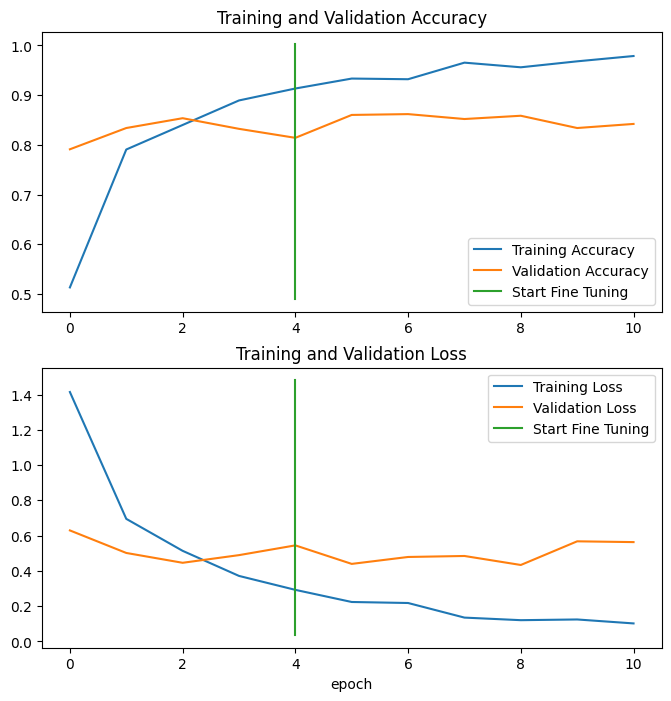

In [57]:
compare_history(history_10_percent_data_aug,history_fine_10_percent_data_aug,initial_epochs=5)